# `xarray` Processing with `matplotlib`

---

Author: Riley X. Brady

Date: October 22nd, 2019

Contact: 
* riley.brady@colorado.edu
* www.rileyxbrady.com

---

`xarray` extends all of the functionality of `numpy` to *labeled* arrays. Since climate data is highly dimensional (e.g. time, lat, lon, depth), this is extremely useful and makes for analyzing climate data much easier!

## References

1. [xarray documentation](http://xarray.pydata.org/en/stable/) - Their documentation is some of the best out there for a python package. It's worth reading through some of these pages!

In [1]:
%matplotlib inline
import xarray as xr

# This is generally bad practice. But 'numpy' spits out a lot of warnings since
# we have NaNs on our grid due to coastlines/land. This just makes sure
# they don't get printed out every time.
import warnings
warnings.simplefilter("ignore")

/Users/xfm684/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/xfm684/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## 1. Loading in Our Data

Here we will work with the ERSSTv4 dataset from NOAA ([link](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4)). The original data span 1850-2019, but I subset it to 1920-2018 for Github storage reasons. The data is interpolated to a 2deg x 2deg regular lat/lon grid.

In [2]:
# xarray does a great job with netCDF data, which is a classic data type
# for climate science.
ds = xr.open_dataset('../data/sst.mnmean.v4.1920-2018.nc')

netCDF is an appealing data format since it does a great job at storing metadata (descriptions of your data).

**Dimensions**: We have core dimensions `lat`, `lon`, and `time`.

**Variables**: We have variables that can be assigned only to these dimensions.

* `lat`: is the coordinate variable that describes the `lat` dimension. You see it is just of `lat` dimensionality and actually contains degrees from 90S to 90N.
* `lon`: is the coordinate variable that describes the `lon` dimension. Similarly it runs from 0 to 360 degrees E.
* `sst`: is our main data variable of dimensions ('time', 'lat', 'lon').
* `time`: describes our time dimension with actual dates from January 1920 to December 2018.

In [3]:
print(ds.info())

xarray.Dataset {
dimensions:
	lat = 89 ;
	lon = 180 ;
	time = 1188 ;

variables:
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:long_name = Latitude ;
		lat:actual_range = [ 88. -88.] ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
		lat:coordinate_defines = center ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = Longitude ;
		lon:actual_range = [  0. 358.] ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:coordinate_defines = center ;
	float32 sst(time, lat, lon) ;
		sst:long_name = Monthly Means of Sea Surface Temperature ;
		sst:units = degC ;
		sst:var_desc = Sea Surface Temperature ;
		sst:level_desc = Surface ;
		sst:statistic = Mean ;
		sst:actual_range = [-1.8  33.95] ;
		sst:valid_range = [-5. 40.] ;
		sst:dataset = NOAA Extended Reconstructed SST V4 ;
		sst:parent_stat = Individual Values ;
	datetime64[ns] time(time) ;
		time:long_name = Time ;
		time:delta_t = 0000-01-00 00:00:00 ;
		time:avg_period = 0000-01-00 00:00:00 ;
		time:pre

## 2. Simple Manipulation of our Dataset

From here on out, we're just working with the SST variable from our dataset, so we'll extract that. `xarray` Datasets can hold multiple variables (e.g., sea surface temperature, salinity, chlorophyll) if you want to do the same operations to a lot of variables at once.

In [4]:
ds = ds['sst']
print(ds)

<xarray.DataArray 'sst' (time: 1188, lat: 89, lon: 180)>
[19031760 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2018-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    actual_range:  [-1.8  33.95]
    valid_range:   [-5. 40.]
    dataset:       NOAA Extended Reconstructed SST V4
    parent_stat:   Individual Values


### 2.1 Means

`xarray` makes it easy to do operations over specific dimensions. For instance, we can take the mean across all time without worrying what dimension number time is.

(The equivalent `numpy` operation here would be `np.nanmean(ds, axis=0)` which requires us to remember/keep track of which axis the time dimension is.

In [5]:
time_mean = ds.mean('time')
#could do .sum .stddev etc.

In [6]:
print(time_mean)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[-1.79678 , -1.796452, -1.796191, ..., -1.797613, -1.797268, -1.796932],
       [-1.794936, -1.794322, -1.793707, ..., -1.797613, -1.796755, -1.795803],
       [-1.792831, -1.791155, -1.789716, ..., -1.796426, -1.795525, -1.794111],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0


`xarray` features a really robust plotting package. That won't be the focus of this notebook, but you can look at all the awesome features here: http://xarray.pydata.org/en/stable/plotting.html

You'll notice that it's really just pulling functionality from `matplotlib` without you having to worry about it.

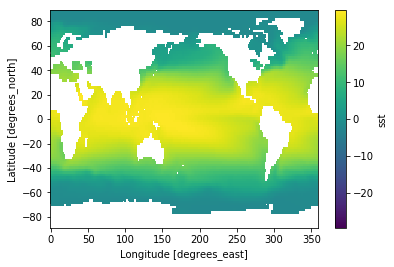

In [7]:
time_mean.plot(cmap='viridis')

Because we have our time axis described from dates, we can very easily take a mean over a specific slice of time. This is a **headache** in languages like `MATLAB` or just using `numpy`. You have to know exactly what indices your time frame spans, and have to account for whether the language is 0-based indexing or 1-based indexing.

In [8]:
ds.time

<xarray.DataArray 'time' (time: 1188)>
array(['1920-01-01T00:00:00.000000000', '1920-02-01T00:00:00.000000000',
       '1920-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80231.]

In [9]:
ds.sel(time=slice('1970', '2000'))

<xarray.DataArray 'sst' (time: 372, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 .

In [10]:
# We use the .sel() operator which can select over some portion of your index.
# First let's prove that it's the correct time slice.
print(ds.sel(time=slice('1970', '2000')))

#there's also .isel() which does it like in the past .sel lets us pick labels

<xarray.DataArray 'sst' (time: 372, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 .

Text(0.5, 1.0, '1970-2000 SST Climatology')

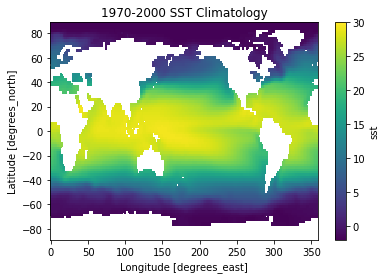

In [11]:
import matplotlib.pyplot as plt

# Now we can take the mean over that slice.
time_mean = ds.sel(time=slice('1970', '2000')).mean('time')

# We can use what we learned about matplotlib here as well.
f, ax = plt.subplots()
time_mean.plot(ax=ax, cmap='viridis', vmin=-2, vmax=30)

ax.set_title('1970-2000 SST Climatology')

<strong><span style="color:red">Try taking means over different time slices and plotting them.</span></strong> You can also designate the month to start/end your slice on, e.g.:

`ds.sel(time=slice('1993-12', '1995-01'))` 

will slice from Dec. 1993 to January 1995.

Text(0.5, 1.0, 'December 1993 to January 1995 SST Climatology')

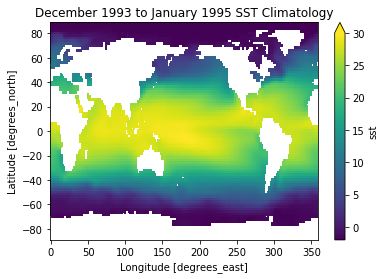

In [12]:
# Now we can take the mean over that slice.
time_mean = ds.sel(time=slice('1993-12', '1995-01')).mean('time')

# We can use what we learned about matplotlib here as well.
f, ax = plt.subplots()
time_mean.plot(ax=ax, cmap='viridis', vmin=-2, vmax=30)

ax.set_title('December 1993 to January 1995 SST Climatology')

We can leverage this to look at the change in Sea Surface Temperatures over this observed period. Let's take a 1999-2018 average (20 years) and subtract the 1920-1939 average from it.

In [13]:
# Take 20-year slices in the same way as before
later_period = ds.sel(time=slice('1999', '2018')).mean('time')
earlier_period = ds.sel(time=slice('1920', '1939')).mean('time')

Now we just subtract those two to get a change over time. This is similar to a linear trend, but instead we are just taking climatologies at either end of the time series.

In [14]:
delta_sst = later_period - earlier_period

Now we can plot it! Here I use some features from the `xarray` plotting package that are outlined in the [documentation](http://xarray.pydata.org/en/stable/plotting.html).

You can see the "warming hole" off Greenland due to freshwater discharge from glacial melt.

Text(0.5, 1.0, 'Change in Sea Surface Temperature\n [1999-2018 minus 1920-1939]')

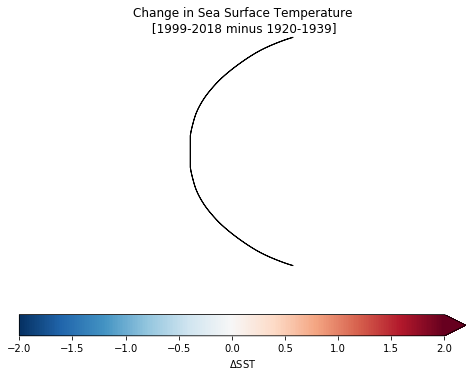

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

f, ax = plt.subplots(figsize=(8,6),
                     subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

delta_sst.plot(# Make sure you assign the geo-axis here.
                ax=ax, 
                # We're going to a funky projection, so need to
                # transform
                transform=ccrs.PlateCarree(),
                # Set the colormap bounds
                vmin=-2, vmax=2, cmap='RdBu_r',
                cbar_kwargs={'orientation': 'horizontal',
                            'label': '$\Delta$SST'})

ax.add_feature(cfeature.LAND, color='k', zorder=4)
ax.set_title('Change in Sea Surface Temperature\n [1999-2018 minus 1920-1939]')

<strong><span style="color:red">Try plotting the difference over your own time slice. Or perhaps mess with the colormap and map projection.</span></strong> You also don't need to *slice* over time. You could select a single time and plot that (e.g., your birthday month):

`ds.sel(time='1993-12)`

## 2.2 Climatologies

Climatologies are classic in the climate sciences. Above we just looked at climatological conditions over a set of years, e.g., a 30 year span. What about a monthly climatology? What does January *usually* look like over this time period?

In [16]:
# Let's first slice to a modern period, so that the long-term warming trend doesn't 
# influence our results too much.
modern_slice = ds.sel(time=slice('1995', '2015'))

`xarray` leverages `pandas` to have an amazingly simple command to get our climatology. We just simply group our data by a certain standard (`.groupby()`) and then apply a simple function over it (in our case, the mean).

In return, we get a Dataset with a new dimension called `month`. This holds our January average SST, February, and so on over 1995 to 2005.

In [17]:
# It's this easy!
monthly_clim = modern_slice.groupby('time.month').mean('time')

print(monthly_clim)

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
array([[[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.789523, -1.787619, ..., -1.798571, -1.797142],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.796666, -1.788571, ..., -1.8     , -1.8     ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.79619 , -1.793809, ..., -1.8     , -1.798095],
        ...,
        [      nan,       nan, ...,       nan, 

Under the hood, it's actually finding every time index that meets the standards of a certain month. So here it's saying the Januarys should be the mean over index 0, 12, 24, ... and so on.

In [18]:
print(modern_slice.groupby('time.month').groups)

{1: [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240], 2: [1, 13, 25, 37, 49, 61, 73, 85, 97, 109, 121, 133, 145, 157, 169, 181, 193, 205, 217, 229, 241], 3: [2, 14, 26, 38, 50, 62, 74, 86, 98, 110, 122, 134, 146, 158, 170, 182, 194, 206, 218, 230, 242], 4: [3, 15, 27, 39, 51, 63, 75, 87, 99, 111, 123, 135, 147, 159, 171, 183, 195, 207, 219, 231, 243], 5: [4, 16, 28, 40, 52, 64, 76, 88, 100, 112, 124, 136, 148, 160, 172, 184, 196, 208, 220, 232, 244], 6: [5, 17, 29, 41, 53, 65, 77, 89, 101, 113, 125, 137, 149, 161, 173, 185, 197, 209, 221, 233, 245], 7: [6, 18, 30, 42, 54, 66, 78, 90, 102, 114, 126, 138, 150, 162, 174, 186, 198, 210, 222, 234, 246], 8: [7, 19, 31, 43, 55, 67, 79, 91, 103, 115, 127, 139, 151, 163, 175, 187, 199, 211, 223, 235, 247], 9: [8, 20, 32, 44, 56, 68, 80, 92, 104, 116, 128, 140, 152, 164, 176, 188, 200, 212, 224, 236, 248], 10: [9, 21, 33, 45, 57, 69, 81, 93, 105, 117, 129, 141, 153, 165, 177, 189, 201, 213, 225, 237

Now we can plot our monthly climatology very easy!

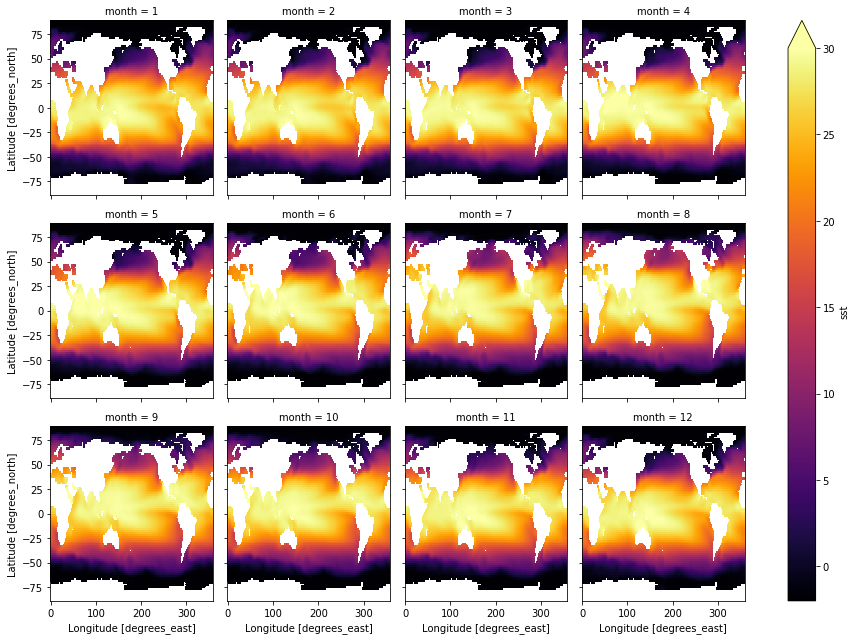

In [19]:
# Here I use `col='month'` to say that I want each individual plot to be a month
# and col_wrap so that it doesn't just put 12 in a line.
monthly_clim.plot(col='month', col_wrap=4, vmin=-2, vmax=30,
                  cmap='inferno')

It's hard to see the differences here, so we could just subtract out the mean over that slice to show the seasonal cycle.

In [20]:
seasonal_cycle_anomalies = monthly_clim - modern_slice.mean('time')

Now we can see the progression of the seasonal cycle!

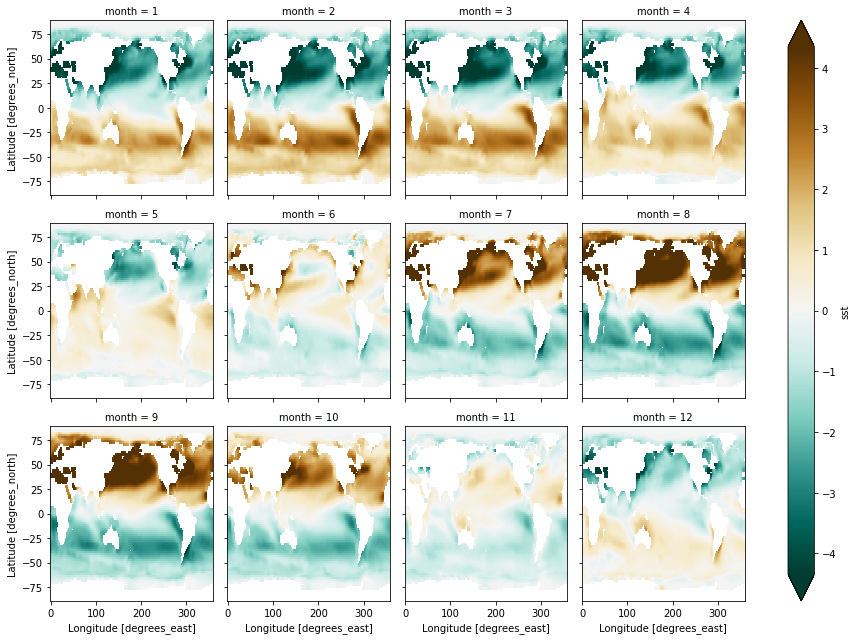

In [21]:
seasonal_cycle_anomalies.plot(col='month', col_wrap=4, robust=True,
                              cmap='BrBG_r')

<strong><span style="color:red">Explore here!</span></strong> Try out `.groupby('time.year')` and see what happens.

In [39]:
yearly_clim = modern_slice.groupby('time.year').mean('time')

print(yearly_clim)

<xarray.DataArray 'sst' (year: 21, lat: 89, lon: 180)>
array([[[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.761667, -1.738333, ..., -1.795833, -1.7875  ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        ...,
        [      nan,       nan, ...,       nan,  

In [40]:
yearly_clim.plot(col='yera', col_wrap=4, vmin=-2, vmax=30,
                  cmap='inferno')

ValueError: Only 1d and 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

## 3. Practical Example: Nino3.4 Index

Let's use what we've learned to compute the Nino3.4 index for this dataset. This index gives us a measure of the state of El Niño Southern Oscillation (ENSO). If it's in a positive state, we have an El Niño; if negative, it's a La Niña.

Here's the instructions for computing the index: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

For the Nino3.4 index in particular:
```
Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.
```

Our first step is to find the Nino3.4 box, which spans 5N to 5S and 170W to 120W.

In [22]:
ds = xr.open_dataarray('../data/sst.mnmean.v4.1920-2018.nc')

In [23]:
# Note that the longitude spans 0 to 360, starting at the Prime Meridian.
lon1 = -170 + 360
lon2 = -120 + 360

# We can use our same knowledge of indexing here!
nino34_box = ds.sel(lat=slice(5, -5), lon=slice(lon1, lon2))

In [24]:
nino34_box

<xarray.DataArray 'sst' (time: 1188, lat: 5, lon: 26)>
[154440 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 4.0 2.0 0.0 -2.0 -4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2018-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    actual_range:  [-1.8  33.95]
    valid_range:   [-5. 40.]
    dataset:       NOAA Extended Reconstructed SST V4
    parent_stat:   Individual Values

Looks like we selected the right box!

In [25]:
# Correct for 0 to 360 lon
print(nino34_box.lon - 360)

<xarray.DataArray 'lon' (lon: 26)>
array([-170., -168., -166., -164., -162., -160., -158., -156., -154., -152.,
       -150., -148., -146., -144., -142., -140., -138., -136., -134., -132.,
       -130., -128., -126., -124., -122., -120.], dtype=float32)
Coordinates:
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0


In [26]:
print(nino34_box.lat)

<xarray.DataArray 'lat' (lat: 5)>
array([ 4.,  2.,  0., -2., -4.], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.0 2.0 0.0 -2.0 -4.0
Attributes:
    units:               degrees_north
    long_name:           Latitude
    actual_range:        [ 88. -88.]
    standard_name:       latitude
    axis:                Y
    coordinate_defines:  center


Now we need to take the mean over this box. We know how to do that! `xarray` can take a list of dimensions to perform the operation over to make things easier.

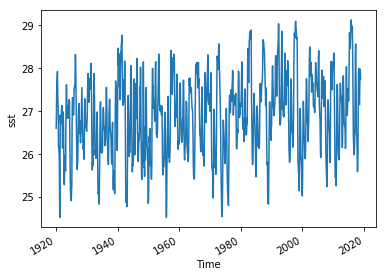

In [27]:
nino34_averaged = nino34_box.mean(['lat', 'lon'])
nino34_averaged.plot()

The instructions say to take a 5-month running mean. This is to get over the fact that the raw data (above) are pretty noisy.

Fortunately, `xarray` has a `rolling` function to take what they call a "rolling" mean: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rolling.html

In [28]:
# Take a rolling mean over 5-months.
nino34_smoothed = nino34_averaged.rolling(time=5).mean()

print(nino34_smoothed)

<xarray.DataArray (time: 1188)>
array([      nan,       nan,       nan, ..., 27.515488, 27.577673, 27.68729 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2018-12-01


By taking a running mean, we average over 5 months, so we lose the first 4 time steps to NaNs. Let's get rid of those.

In [29]:
nino34_smoothed = nino34_smoothed.dropna('time')

Here's what this just did. It smooths by a bit, but not a ton since it's only 5 months.

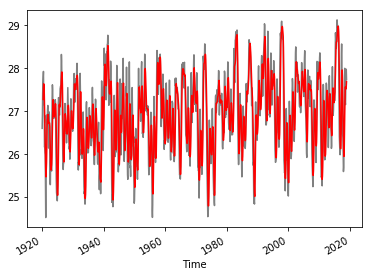

In [30]:
# The original, noisy SST averages.
nino34_averaged.plot(color='gray')
# The smoothed version.
nino34_smoothed.plot(color='r')

In [31]:
# Take a rolling mean over 5-months.
nino34_smoothed = nino34_averaged.rolling(time=12).mean()

print(nino34_smoothed)

<xarray.DataArray (time: 1188)>
array([      nan,       nan,       nan, ..., 26.981825, 27.14423 , 27.323551],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2018-12-01


By taking a running mean, we average over 5 months, so we lose the first 4 time steps to NaNs. Let's get rid of those.

In [32]:
nino34_smoothed = nino34_smoothed.dropna('time')

Here's what this just did. It smooths by a bit, but not a ton since it's only 5 months.

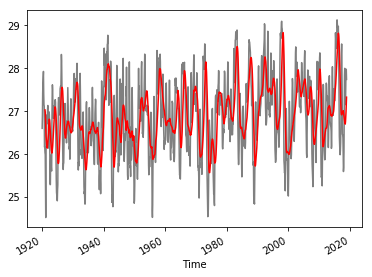

In [33]:
# The original, noisy SST averages.
nino34_averaged.plot(color='gray')
# The smoothed version.
nino34_smoothed.plot(color='r')

Lastly we should detrend our time series so that we remove the climate change signal *and* can look at anomalies to meet their criteria of exceeding +/- 0.4C. Unfortunately, `xarray` doesn't have a `detrend` function, so we'll just leverage `scipy` here.

In [34]:
from scipy.signal import detrend
NINO34 = detrend(nino34_smoothed)

In [35]:
# The above operation returned a numpy object. So we're just going to
# recreate it as an xarray object to get all of the plotting functionality back.
ds = xr.DataArray(NINO34, dims='time', coords=[nino34_smoothed.time])

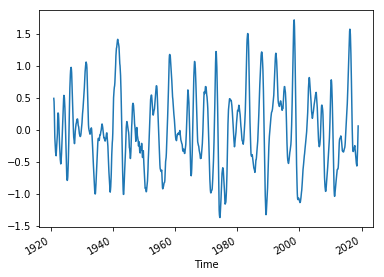

In [36]:
# Our Nino3.4 index!
ds.plot()

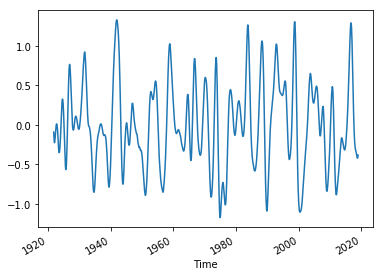

In [37]:
ds.rolling(time=12).mean().plot()

This is a bit more advanced, but let's use `xarray` to make a nice colored plot highligthing El Niño and La Niña events. To classify actual events, you'd actually need to find where e.g. the index is above 0.4C for 6 months straight to be an El Niño. Here we just color by red and blue if it's positive or negative.

Text(0.5, 1.0, 'ENSO Index over 1920-2018 in ERSSTv4')

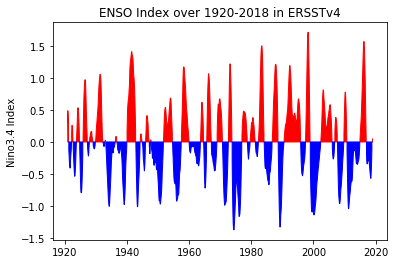

In [38]:
f, ax = plt.subplots()

# Isolate positive and negative months based on these simple conditions
el_nino = ds.where(ds > 0)
la_nina = ds.where(ds < 0)
                  
ax.fill_between(el_nino['time'].values, el_nino.values, color='r')
ax.fill_between(la_nina['time'].values, la_nina.values, color='b')

ax.set_ylabel('Nino3.4 Index')
ax.set_title('ENSO Index over 1920-2018 in ERSSTv4')

<strong><span style="color:red">If you're feeling inspired, try creating an index following one of the other ENSO conventions (e.g. Nino4 or Nino1+2).</span></strong> Does it look much different?